Hunter Bennett | Glass Lab | Brain Aging Project | 19 Feb 2021

This notebook uses the peak files generated in the prior notebook to call motifs. As mentioned in the lead-in to that notebook we are a little unsure of what peak sets to use for our analyses, but right now there are three possible methods:

1. Call motifs across 1000bp broad peaks.
2. Call motifs on HOMER identified nucleosome free regions.
3. Call motifs on HisTrader identified nucleosome free regions.

So we will try each of these in this notebook and see what each yield!

This notebook also plots the results of knownMotif analysis as a heatmap to make comparisons across analyses easier.

In [4]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/NeuN/'
workingDirectory = '/home/h1bennet/brain_aging/results/01_NeuN_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Check how many peaks are in the histrader files

In [25]:
!wc -l ./4month_vs_25month/bed_files/*

  2023 ./4month_vs_25month/bed_files/00_neun_4month_union_act_peaks.bed
    20 ./4month_vs_25month/bed_files/01_neun_25month_union_act_peaks.bed
  2043 total


In [22]:
!wc -l ./4month_vs_25month/histrader/0*nfr.bed

  24866 ./4month_vs_25month/histrader/00_neun_4month_act_histrader.nfr.bed
    178 ./4month_vs_25month/histrader/01_neun_25month_act_histrader.nfr.bed
  25044 total


# Call motifs

In [7]:
if not os.path.isdir('./4month_vs_25month/motif_calling/'):
    os.mkdir('./4month_vs_25month/motif_calling/')

### Run on HisTrader peaks

In [ ]:
%%bash
# delete the existing script file
rm ./4month_vs_25month/findMotifs_histrader.sh
# create a script file
touch ./4month_vs_25month/findMotifs_histrader.sh

In [9]:
%%bash
for i in ./4month_vs_25month/histrader/*nfr.txt;
do out=${i/.nfr.txt/_motifs_nobg}
out=${out/histrader/motif_calling}
echo "findMotifsGenome.pl $i mm10 $out -len 8,10,12,14,16 -size 200 -p 16" >> ./4month_vs_25month/findMotifs_histrader.sh
done

## Run on full acetylated regions

In [12]:
%%bash
# delete the existing script file
rm ./4month_vs_25month/findMotifs_broadPeaks.sh
# create a script file
touch ./4month_vs_25month/findMotifs_broadPeaks.sh

In [13]:
%%bash
for i in ./4month_vs_25month/bed_files/*union_act_peaks.bed;
do out=${i/peaks.bed/motifs_nobg}
out=${out/bed_files/motif_calling}
out=${out/union/region}
echo "findMotifsGenome.pl $i mm10 $out -len 8,10,12,14,16 -size 1000 -p 16" >> ./4month_vs_25month/findMotifs_broadPeaks.sh
done

## Run on homer NFRs

In [17]:
%%bash
# delete the existing script file
rm ./4month_vs_25month/findMotifs_homer.sh
# create a script file
touch ./4month_vs_25month/findMotifs_homer.sh

In [18]:
%%bash
for i in ./4month_vs_25month/homer_nfr/*;
do out=${i/peaks.bed/motifs_nobg}
out=${out/homer_nfr/motif_calling}
echo "findMotifsGenome.pl $i mm10 $out -len 8,10,12,14,16 -size 200 -p 16" >> ./4month_vs_25month/findMotifs_homer.sh
done

# Visualize Motifs
____
All enhancers

In [6]:
!ls ./4month_vs_25month/motif_calling/*/knownResults.txt

./4month_vs_25month/motif_calling/00_neun_4month_act_histrader_motifs_nobg/knownResults.txt
./4month_vs_25month/motif_calling/00_neun_4month_homer_nfr_act_motifs_nobg/knownResults.txt
./4month_vs_25month/motif_calling/00_neun_4month_region_act_motifs_nobg/knownResults.txt
./4month_vs_25month/motif_calling/01_neun_25month_act_histrader_motifs_nobg/knownResults.txt


In [13]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob('./4month_vs_25month/motif_calling/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)

    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]

    # extract name of sample
    sample = f.split('/')[3]

    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame.to_csv('./homer_known_motifs_log.txt', sep='\t')

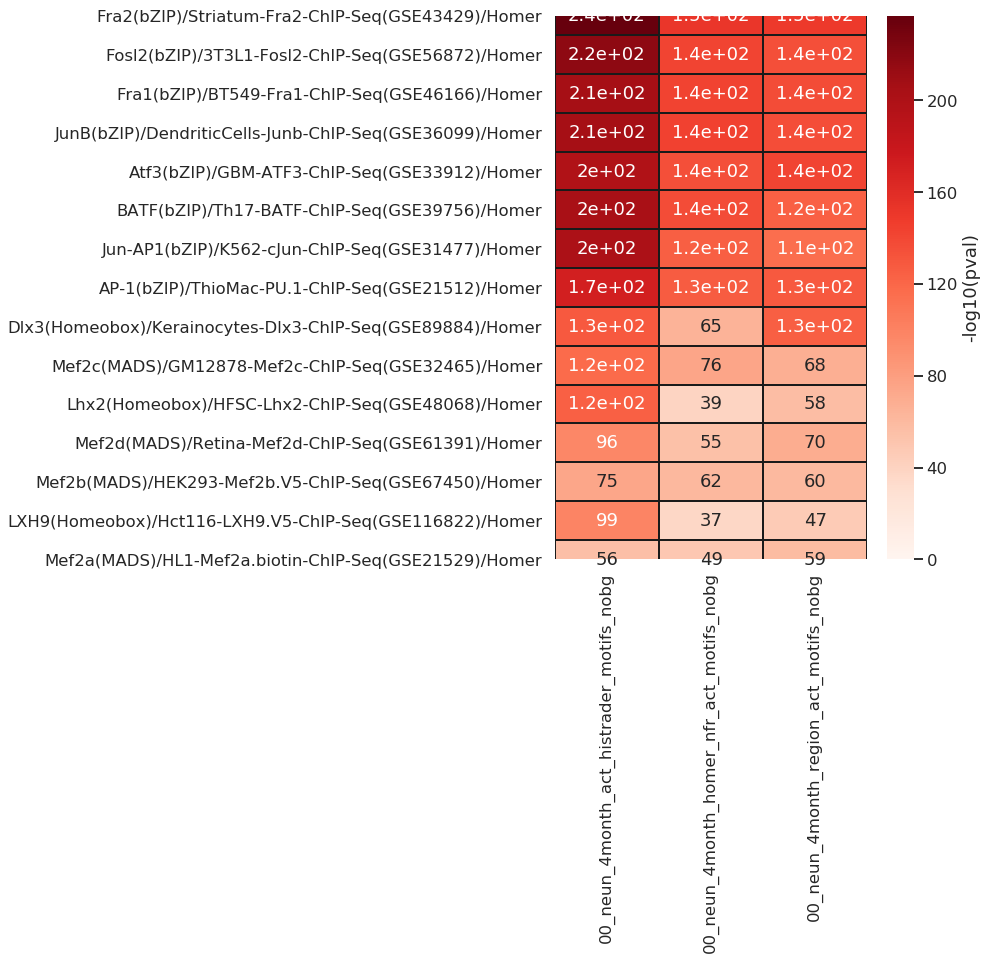

In [16]:
fig, ax = plt.subplots(figsize=(7,10))

sns.heatmap(
    -known_motif_pval_frame.loc[:,
                                known_motif_pval_frame.columns.str.contains('00_neun_4month')].head(15),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    vmin=0,
    ax=ax)

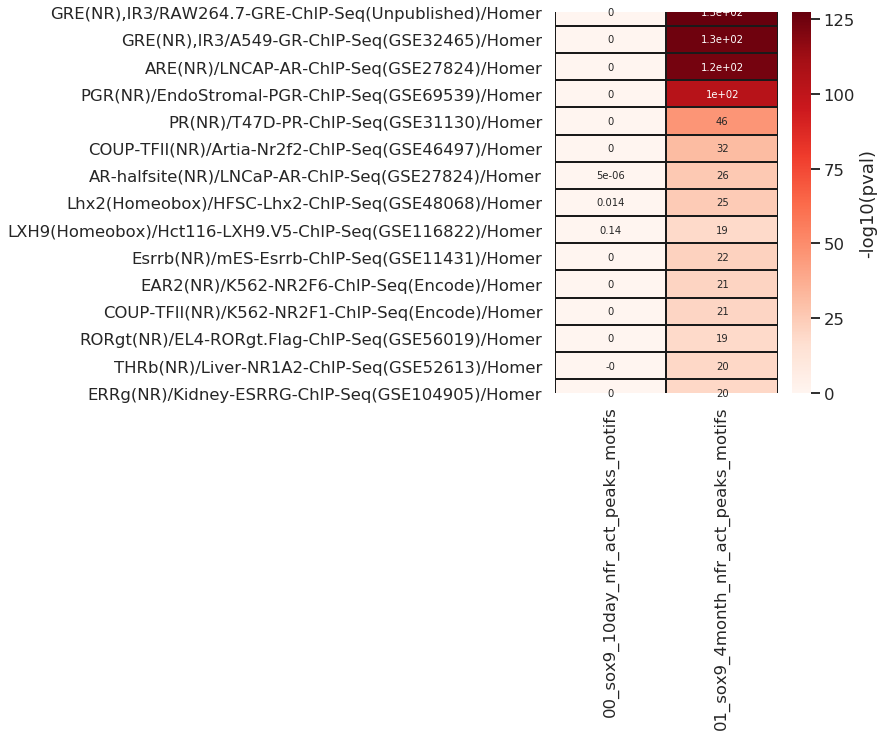

In [5]:
fig, ax = plt.subplots(figsize=(5,7))

sns.heatmap(
    -known_motif_pval_frame.loc[(known_motif_pval_frame <=-6).any(axis=1),
                                ~known_motif_pval_frame.columns.str.contains('distal')].head(15),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    vmin=0,
    ax=ax)

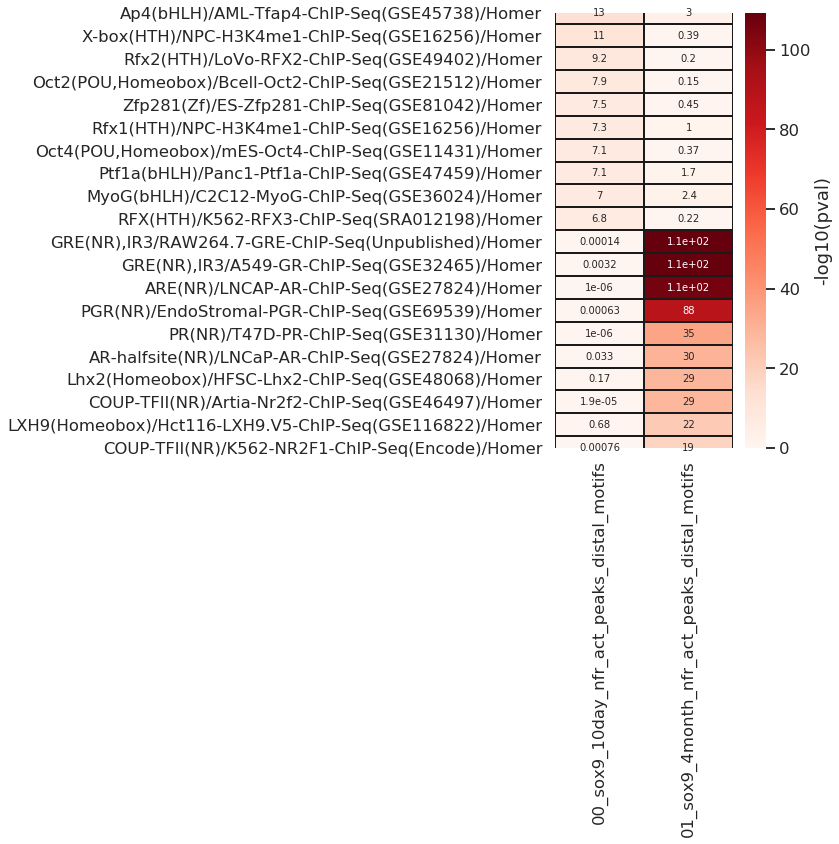

In [20]:
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('distal')]

motif_list = []
n_motifs = 10
for col in tmp_frame.columns:
    motif_list.extend(tmp_frame.sort_values(col).index.tolist()[:n_motifs])

fig, ax = plt.subplots(figsize=(4,8))

sns.heatmap(
    -tmp_frame.loc[motif_list, :],
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    vmin=0,
    ax=ax)